<a href="https://colab.research.google.com/github/Ayman-Abdeen/chatboot-/blob/main/chatbot/BiLSTM%2BAttention/model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install --user -U nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from keras import backend as K
from keras.layers import Layer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import itertools

'''
This configuration file provides a series of predefined functions
'''


# ------------------custom function------------------ #

def text_to_word_list(text):  # 文本分词
    text = str(text)
    text = text.lower()
    # Text cleaning rules for English text
    import re
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

def make_w2v_embeddings(flag, word2vec, df, embedding_dim):  # 将词转化为词向量
    vocabs = {}  # 词序号
    vocabs_count = 0  # 词个数计数器

    vocabs_not_w2v = {}  # 无法用词向量表示的词
    vocabs_not_w2v_count = 0  # Word count that cannot be represented by word vectors

    # 停用词
    # stops = set(open('data/stopwords.txt').read().strip().split('\n'))

    for index, row in df.iterrows():
        # 打印处理进度
        if index != 0 and index % 1000 == 0:
            print(str(index) + " sentences embedded.")

        for question in ['question1', 'question2']:
            q2n = []  # q2n -> question to numbers representation
            words = text_to_word_list(row[question])

            for word in words:
                # if word in stops:  # remove stop words
                # continue
                # The word of OOV is put into a dictionary that cannot be represented by a word vector, and the value is 1
                if word not in word2vec and word not in vocabs_not_w2v:  
                    vocabs_not_w2v_count += 1
                    vocabs_not_w2v[word] = 1   
                if word not in vocabs:  # Non-OOV words, extract the corresponding id
                    vocabs_count += 1
                    vocabs[word] = vocabs_count
                    q2n.append(vocabs_count)
                else:
                    q2n.append(vocabs[word])
            df.at[index, question + '_n'] = q2n

    embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)  # 随机初始化一个形状为[全部词个数，词向量维度]的矩阵
    '''
    词1 [a1, a2, a3, ..., a60]
    词2 [b1, b2, b3, ..., b60]
    词3 [c1, c2, c3, ..., c60]
    '''
    embeddings[0] = 0  # 第一行用0填充，因为不存在index为0的词

    for index in vocabs:
        vocab_word = vocabs[index]
        if vocab_word in word2vec:
            embeddings[index] = word2vec[vocab_word]
    del word2vec

    return df, embeddings


def split_and_zero_padding(df, max_seq_length):  # 调整tokens长度

    # 训练集矩阵转换成字典
    X = {'left': df['question1_n'], 'right': df['question2_n']}

    # 调整到规定长度
    for dataset, side in itertools.product([X], ['left', 'right']):
        dataset[side] = pad_sequences(dataset[side], padding='pre', truncating='post', maxlen=max_seq_length)

    return dataset


class ManDist(Layer):  # 封装成keras层的曼哈顿距离计算

    # 初始化ManDist层，此时不需要任何参数输入
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # Automatically build ManDist layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # Calculate Manhattan distance
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return result
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)



class Euc_dist_keras(Layer):  # 封装成keras层的曼哈顿距离计算

    # 初始化ManDist层，此时不需要任何参数输入
    def __init__(self, **kwargs):
        self.result = None
        super(Euc_dist_keras, self).__init__(**kwargs)

    # Automatically build ManDist layer
    def build(self, input_shape):
        super(Euc_dist_keras, self).build(input_shape)

    # Calculate Manhattan distance

    def call(self, x, **kwargs):
        self.result = K.sqrt(K.sum(K.square(K.abs(x[0] - x[1])), axis=-1, keepdims=True))
        return self.result

    # return result
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [6]:
# Basic package
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Lambda, \
    Bidirectional, TimeDistributed, Dropout, Conv1D, GlobalMaxPool1D
from keras.layers.merge import multiply, concatenate
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [7]:
!pip install wget

In [ ]:
#!pip install wget

import wget
url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
filename = wget.download(url)

In [ ]:
! pip install kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download quora-question-pairs -f train.csv.zip
#! kaggle competitions download quora-question-pairs -f test.csv.zip

 24% 5.00M/21.2M [00:00<00:00, 20.8MB/s]
100% 21.2M/21.2M [00:00<00:00, 60.9MB/s]


In [ ]:
#! unzip -o test.csv.zip
! unzip -o train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
url = ''
filename = wget.download(url)

In [ ]:
!wget https://github.com/14H034160212/HHH-An-Online-Question-Answering-System-for-Medical-Questions/blob/master/Data/Model_train_dev_test_dataset/Other_model_train_dev_test_dataset/train.csv

--2022-01-26 00:41:27--  https://github.com/14H034160212/HHH-An-Online-Question-Answering-System-for-Medical-Questions/blob/master/Data/Model_train_dev_test_dataset/Other_model_train_dev_test_dataset/train.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train.csv’

train.csv               [ <=>                ] 174.29K  --.-KB/s    in 0.03s   

2022-01-26 00:41:27 (5.27 MB/s) - ‘train.csv’ saved [178472]



In [22]:
# ------------------Preloading------------------ #

# Chinese and English training options, English training set is used by default
TRAIN_CSV = './train_K.csv'
TRAIN_CSV_git = './train.csv'
flag = 'en'
embedding_path = 'GoogleNews-vectors-negative300.bin.gz'
embedding_dim = 300
max_seq_length = 12
savepath = './en_SiameseLSTM.h5'

In [23]:
# Whether to enable pre-trained word vectors, use randomly initialized word vectors by default
# Load word vectors
print("Loading word2vec model(it may takes 2-3 mins) ...")
embedding_dict = KeyedVectors.load_word2vec_format(embedding_path, binary=True)


Loading word2vec model(it may takes 2-3 mins) ...


In [24]:
# Read and load the training set
train_df = pd.read_csv(TRAIN_CSV_git)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

In [ ]:
# Read and load the training set
train_df_kaggle = pd.read_csv(TRAIN_CSV)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

In [25]:
%%time
# Vectorize the training set words
train_df, embeddings = make_w2v_embeddings(flag, embedding_dict, train_df, embedding_dim=embedding_dim)

1000 sentences embedded.
2000 sentences embedded.
3000 sentences embedded.
4000 sentences embedded.
5000 sentences embedded.
6000 sentences embedded.
7000 sentences embedded.
8000 sentences embedded.
9000 sentences embedded.
CPU times: user 2.83 s, sys: 26.3 ms, total: 2.85 s
Wall time: 2.83 s


In [26]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_n,question2_n
0,31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[17, 18, 19, 20, 21, 10, 22, 23, 13, 24, 16]"
1,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[25, 26, 27, 28, 6, 29, 30, 31, 32]","[17, 25, 26, 27, 33, 34, 6, 29, 30, 31]"
2,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[25, 26, 27, 28, 6, 29, 30, 31, 32]","[17, 25, 26, 27, 33, 34, 6, 29, 30, 31]"
3,58,117,118,I was suddenly logged off Gmail. I can't remem...,I can't remember my Gmail password or my recov...,1,"[19, 35, 36, 37, 38, 39, 19, 40, 41, 21, 39, 4...","[19, 40, 41, 21, 39, 42, 52, 21, 46, 47, 17, 1..."
4,61,123,124,Is it normal to have a dark ring around the ir...,What causes a dark ring around the iris? How s...,0,"[25, 54, 55, 56, 57, 9, 58, 59, 60, 15, 61, 62...","[1, 64, 9, 58, 59, 60, 15, 61, 17, 65, 54, 66,..."


In [27]:
train_df.shape

(9998, 8)

In [ ]:
train_df.shape

(404290, 8)

In [28]:
plotBar=train_df["is_duplicate"].value_counts()
plotBar

1    4999
0    4999
Name: is_duplicate, dtype: int64

In [ ]:
plotBar=train_df["is_duplicate"].value_counts()
plotBar

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
train_df.groupby("is_duplicate")['id'].count().plot.bar()

<BarContainer object of 2 artists>

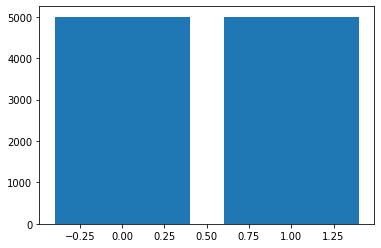

In [29]:
plt.bar(plotBar.index,plotBar)

<BarContainer object of 2 artists>

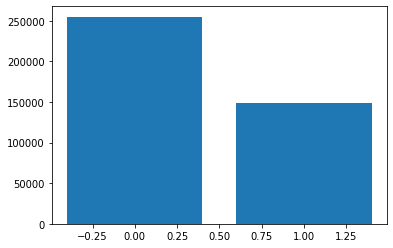

In [ ]:
plt.bar(plotBar.index,plotBar)

In [30]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.mean(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.mean(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 12.
Average word length of questions in question2 is 12.


In [ ]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.mean(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.mean(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 11.
Average word length of questions in question2 is 11.


In [31]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.max(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.max(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 57.
Average word length of questions in question2 is 57.


In [ ]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.max(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.max(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 125.
Average word length of questions in question2 is 237.


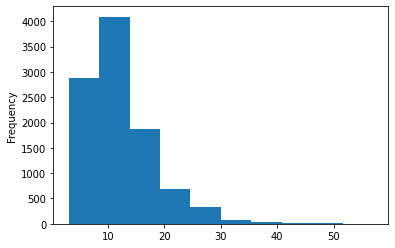

In [32]:
train_df['question1'].astype(str).apply(lambda x: len(x.split())).plot(kind='hist');

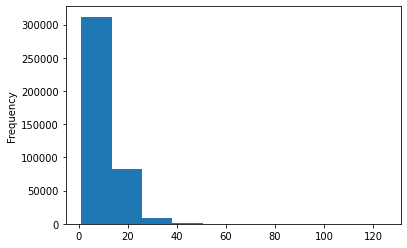

In [ ]:
train_df['question1'].astype(str).apply(lambda x: len(x.split())).plot(kind='hist');


In [ ]:
@@@@@@@@@@@@@@@ff
train_df['lenq1'] = train_df['question1'].astype(str).str.len()
train_df['lenq2'] = train_df['question2'].astype(str).str.len()
train_df['lenq1_n'] = train_df['question1_n'].str.len()
train_df['lenq2_n'] = train_df['question2_n'].str.len()

train_df

In [ ]:
@@@@@@@@@@@@@@
plt.plot(train_df['lenq2_n'].value_counts(), train_df['lenq2_n'])
plt.show()
plt.plot(train_df['lenq2_n'],'o')
plt.show()

In [ ]:
@@@@@@@@@@@@
train_df['lenq1'].max()

623

In [ ]:
@@@@@@@@@@@@@@@
train_df['lenq2'].max()

1169

In [ ]:
@@@@@@@@@@@@@@@@@@@@@@@2
for col in [('question1','lenq1'),('question2','lenq1')]:
   # find indices, keep="all" means keep all occurrences. 
   idxs = train_df[col[0]].astype(str).str.len().nlargest(1, keep="all").index
   mean = train_df[col[0]].astype(str).str.len().mean()

   # get values.
   values = train_df.loc[idxs,col[1]]
   values2 = train_df.loc[idxs,col[0]]

   print(values)
   print("mean : ",mean)
   print(len(train_df['question1'][4730]))

35101    623
Name: lenq1, dtype: int64
mean :  59.53671621855599
103
4326      149
153442    131
346481    141
Name: lenq1, dtype: int64
mean :  60.108380123178904
103


In [33]:
# max_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).max(),train_df.question2_n.map(lambda x: len(x)).max())
print("max_seq_length_in_dataset : ",max_seq_length_in_dataset)


max_seq_length_in_dataset :  65


In [ ]:
# max_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).max(),train_df.question2_n.map(lambda x: len(x)).max())
print("max_seq_length_in_dataset : ",max_seq_length_in_dataset)


max_seq_length_in_dataset :  244


In [34]:
# mean_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).mean(),train_df.question2_n.map(lambda x: len(x)).mean())
print("mean_seq_length_in_dataset : ",max_seq_length_in_dataset)


mean_seq_length_in_dataset :  12.420184036807361


In [ ]:
# mean_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).mean(),train_df.question2_n.map(lambda x: len(x)).mean())
print("mean_seq_length_in_dataset : ",max_seq_length_in_dataset)


mean_seq_length_in_dataset :  11.413188552771526


Take the training data from:
question1   question2   is_duplicate
borrow Repayment Information Borrow Repayment Date 0
become:

question1 question2 is_duplicate question1_n question2_n
Borrow repayment information Borrow repayment date 0 Borrow repayment information Borrow repayment date

After becoming id:
question1 question2 is_duplicate question1_n question2_n
Borrow repayment information Borrow repayment date 0 [31, 639] [31, 255]

In [35]:
# Split training set
X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)

In [36]:
# Convert labels to numbers
Y_train = Y_train.values
Y_validation = Y_validation.values

In [37]:
# Confirm that the data is prepared and correct
print("X_train['left'].shape" , X_train['left'].shape)
print("X_train['right'].shape" , X_train['left'].shape)
print("len(X_train['left'])" , len(X_train['left']))
print("len(Y_train)" , len(Y_train))

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

X_train['left'].shape (7998, 12)
X_train['right'].shape (7998, 12)
len(X_train['left']) 7998
len(Y_train) 7998


In [38]:
print(Y_validation)

[1 1 0 ... 0 0 0]


# -----------------base function------------------ #


In [39]:
def shared_model(_input):
    # word vectorization
    embedded = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_shape=(max_seq_length,),
                         trainable=False)(_input)

    # multilayerBi-LSTM
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(embedded)
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(activations)

    # dropout
    activations = Dropout(0.5)(activations)

    # Attention
    attention = TimeDistributed(Dense(1, activation='tanh'))(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(n_hidden * 2)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # dropout
    sent_representation = Dropout(0.4)(sent_representation)

    return sent_representation

In [41]:
if __name__ == '__main__':

    # Hyperparameter
    batch_size = 1024
    n_epoch = 15
    n_hidden = 100

    left_input = Input(shape=(max_seq_length,), dtype='float32')
    right_input = Input(shape=(max_seq_length,), dtype='float32')

    left_sen_representation = shared_model(left_input)
    right_sen_representation = shared_model(right_input)

    # The Manhattan distance is introduced, and the original 
    #vector on the obtained transformation concat is 
    #then subjected to a non-linear transformation 
    #through a multi-layer DNN, and the sigmoid obtains the similarity
    
    # I did not use the Mahalanobis distance mentioned 
    #in https://zhuanlan.zhihu.com/p/31638132. 
    #I tried Manhattan distance, point product and cos, 
    #and Manhattan is the best.
    
    man_distance = ManDist()([left_sen_representation, right_sen_representation])
    sen_representation = concatenate([left_sen_representation, right_sen_representation, man_distance])
    similarity = Dense(1, activation='sigmoid')(Dense(2)(Dense(4)(Dense(16)(sen_representation))))
    model = Model(inputs=[left_input, right_input], outputs=[similarity])

    model.compile(loss='mean_squared_error', optimizer= Adam(), metrics=['accuracy'])
    model.summary()

    training_start_time = time()
    malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                               batch_size=batch_size, epochs=n_epoch,
                               validation_data=([X_validation['left'], X_validation['right']], Y_validation))
    training_end_time = time()
    print("Training time finished.\n%d epochs in %12.2f" % (n_epoch, training_end_time - training_start_time))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 12, 300)      3516600     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 12, 300)      3516600     ['input_4[0][0]']                
                                                                                            

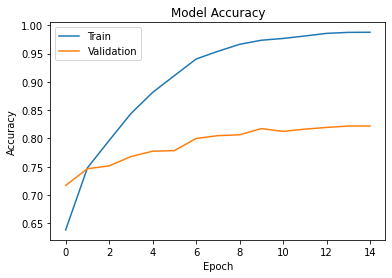

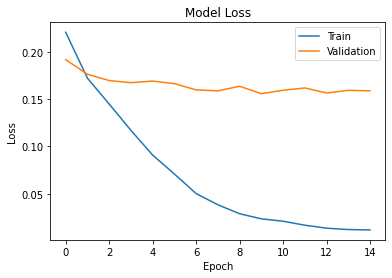

0.8220(max: 0.8220)
Done.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [42]:
# Plot accuracy
import matplotlib.pyplot as plt
#plt.subplot(211)
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
#plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

model.save(savepath)
print(str(malstm_trained.history['val_accuracy'][-1])[:6] + "(max: " + str(max(malstm_trained.history['val_accuracy']))[:6] + ")")
print("Done.")

In [70]:
import json
def readJson(filename):
  with open(filename, 'r') as file:
    intents = json.load(file)
    return intents

In [71]:
icliniqQAs = readJson('icliniqQAs.json')
#webmdQAs = readJson('webmdQAs.json')
questionDoctorQAs = readJson('questionDoctorQAs.json')
ehealthforumQAs = readJson('ehealthforumQAs.json')

all_medical_list = icliniqQAs+questionDoctorQAs+ehealthforumQAs
print(len(icliniqQAs)+len(questionDoctorQAs)+len(ehealthforumQAs))
print(len(all_medical_list))
type(all_medical_list)

all_medical_list[0]

6315
6315


{'answer': 'from your description it appears that you may have anterior knee pain which sometimes presents as pain at the back of the knee. the second possibility is that you have over done your exercise and hamstrings are sore and the lower end of the knee cap is inflamed. either way you should rest and ice the area of pain and give it time. i suggest you add nsaids (nonsteroidal anti-inflammatory drugs) for a week for an additional anti-inflammatory action. for further information consult an orthopaedician and traumatologist online --> <link>',
 'question': 'is it fine to exercise with knee pain?',
 'question_text': '\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 24 year old female. My height is 5\'5" and weight is 58 kg. I am a cyclist and, to a lesser extent, a runner. For the past one\xa0week, I have been getting pain in the back of my left knee. It hurts when I walk and not just doing sport. It is the movement of pushing off from the ground that makes it hurt, and when I straighten my 

In [72]:
import pandas as pd
all_medical_df = pd.DataFrame.from_dict(all_medical_list)
all_medical_df

,answer,question,question_text,tags,url,answer_author
0,from your description it appears that you may ...,is it fine to exercise with knee pain?,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 24 ye...",[exercises],https://www.icliniq.com/qa/knee-pain/is-it-fin...,NaN
1,depression anxiety restlessness and panic atta...,suffering from anxiety restlessness and taking...,"\r\n\r\n\r\n\t\t\t\t\tDear Doctor,\nI am suffe...",[anxiety],https://www.icliniq.com/qa/anxiety/suffering-f...,NaN
2,patients with hypothyroidism usually gain weig...,can a thyroid patient eat soybean and fenugreek?,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,I am a 23 year...",[hypothyroidism],https://www.icliniq.com/qa/thyroid-problem/can...,NaN
3,fenugreek seed cannot affect your fertility do...,i am not getting my periods after taking fenug...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 23 ye...",[delayed period],https://www.icliniq.com/qa/missed-period/i-am-...,NaN
4,your problem is a characteristic of cholinergi...,kindly suggest me a therapy to overcome heat a...,"\r\n\r\n\r\n\t\t\t\t\tHello doctor,\nFrom one ...",[levocetirizine],https://www.icliniq.com/qa/cholinergic-urticar...,NaN
...,...,...,...,...,...,...
6310,what your boyfriend seems to be having is bipo...,i belive my boyfriend is bipolar or has boderl...,NaN,"[smoking pot, bipolar, smoking, abusive, bipol...",http://ehealthforum.com/health/one-minute-he-s...,NaN
6311,depression is common with any comorbid illness...,why do i feel so down when someone makes fun o...,NaN,[dyslexia],http://ehealthforum.com/health/feel-down-about...,NaN
6312,in bipolar disorder sometimes there are mixed ...,please help! my fiance is bipolar but will not...,NaN,"[bipolar, medication, bipolar help, anger help...",http://ehealthforum.com/health/fiance-is-bipol...,NaN
6313,hello. from your description here it seems you...,i constantly have bursts of anger for no reaso...,NaN,"[bipolar disorder, anxiety, bipolar, angry, an...",http://ehealthforum.com/health/constantly-have...,NaN


In [73]:
all_medical_df.drop(columns=['question_text', 'url','answer_author'],inplace = True)
all_medical_df

,answer,question,tags
0,from your description it appears that you may ...,is it fine to exercise with knee pain?,[exercises]
1,depression anxiety restlessness and panic atta...,suffering from anxiety restlessness and taking...,[anxiety]
2,patients with hypothyroidism usually gain weig...,can a thyroid patient eat soybean and fenugreek?,[hypothyroidism]
3,fenugreek seed cannot affect your fertility do...,i am not getting my periods after taking fenug...,[delayed period]
4,your problem is a characteristic of cholinergi...,kindly suggest me a therapy to overcome heat a...,[levocetirizine]
...,...,...,...
6310,what your boyfriend seems to be having is bipo...,i belive my boyfriend is bipolar or has boderl...,"[smoking pot, bipolar, smoking, abusive, bipol..."
6311,depression is common with any comorbid illness...,why do i feel so down when someone makes fun o...,[dyslexia]
6312,in bipolar disorder sometimes there are mixed ...,please help! my fiance is bipolar but will not...,"[bipolar, medication, bipolar help, anger help..."
6313,hello. from your description here it seems you...,i constantly have bursts of anger for no reaso...,"[bipolar disorder, anxiety, bipolar, angry, an..."


In [74]:
test_df = pd.DataFrame(all_medical_df["question"])
test_df.columns = ['question1']

test_df['question2']="i had high pressure?"
test_df

,question1,question2
0,is it fine to exercise with knee pain?,i had high pressure?
1,suffering from anxiety restlessness and taking...,i had high pressure?
2,can a thyroid patient eat soybean and fenugreek?,i had high pressure?
3,i am not getting my periods after taking fenug...,i had high pressure?
4,kindly suggest me a therapy to overcome heat a...,i had high pressure?
...,...,...
6310,i belive my boyfriend is bipolar or has boderl...,i had high pressure?
6311,why do i feel so down when someone makes fun o...,i had high pressure?
6312,please help! my fiance is bipolar but will not...,i had high pressure?
6313,i constantly have bursts of anger for no reaso...,i had high pressure?


In [75]:

import pandas as pd

import tensorflow as tf


# File paths
#TEST_CSV = './data/test-20.csv'

# Load training set
#test_df = pd.read_csv(TEST_CSV)
for q in ['question1', 'question2']:
    test_df[q + '_n'] = test_df[q]

# Make word2vec embeddings
embedding_dim = 300
max_seq_length = 12
test_df, embeddings = make_w2v_embeddings(flag, embedding_dict, test_df, embedding_dim=embedding_dim)

# Split to dicts and append zero padding.
X_test = split_and_zero_padding(test_df, max_seq_length)

# Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape

# --

model = tf.keras.models.load_model('./en_SiameseLSTM.h5', custom_objects={'ManDist': ManDist})
model.summary()

prediction = model.predict([X_test['left'], X_test['right']])

1000 sentences embedded.
2000 sentences embedded.
3000 sentences embedded.
4000 sentences embedded.
5000 sentences embedded.
6000 sentences embedded.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 12, 300)      3516600     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 12

In [76]:
test_df.shape

(6315, 4)

In [77]:
prediction.shape

(6315, 1)

In [78]:
Eval = pd.DataFrame(columns= ['question1','question2','prediction'])
Eval['question1']= test_df['question1']
Eval['question2']=test_df['question2']
Eval['prediction']= prediction
Eval

,question1,question2,prediction
0,is it fine to exercise with knee pain?,i had high pressure?,2.139866e-03
1,suffering from anxiety restlessness and taking...,i had high pressure?,1.400039e-01
2,can a thyroid patient eat soybean and fenugreek?,i had high pressure?,9.301603e-04
3,i am not getting my periods after taking fenug...,i had high pressure?,5.674534e-06
4,kindly suggest me a therapy to overcome heat a...,i had high pressure?,2.972963e-02
...,...,...,...
6310,i belive my boyfriend is bipolar or has boderl...,i had high pressure?,1.949880e-05
6311,why do i feel so down when someone makes fun o...,i had high pressure?,1.384959e-05
6312,please help! my fiance is bipolar but will not...,i had high pressure?,5.200207e-04
6313,i constantly have bursts of anger for no reaso...,i had high pressure?,3.393583e-06


In [80]:
B_sorted = Eval.sort_values(["prediction"], ascending='false')
B_sorted.tail(10)

,question1,question2,prediction
3525,fetal echo cardiography done doctors suggested...,i had high pressure?,0.946257
3527,fetal echo cardiography done doctors suggested...,i had high pressure?,0.946257
3526,fetal echo cardiography done doctors suggested...,i had high pressure?,0.946257
3524,fetal echo cardiography done doctors suggested...,i had high pressure?,0.946257
42,is it true that schizophrenia runs in family?,i had high pressure?,0.964717
6054,i just overdosed,i had high pressure?,0.966253
6053,i just overdosed,i had high pressure?,0.966253
5735,lower stomach is swollen and quite hard breast...,i had high pressure?,0.972986
392,is mymox used to stop lactation?,i had high pressure?,0.988589
1895,sinus issues mucous build up in nose and post ...,i had high pressure?,0.994599


In [79]:
column = Eval["prediction"]
max_index = column.idxmax()
max_index

1895

In [81]:
Eval.iloc[[max_index]]

,question1,question2,prediction
1895,sinus issues mucous build up in nose and post ...,i had high pressure?,0.994599


In [82]:
all_medical_df.iloc[[max_index]]

,answer,question,tags
1895,hi assuming you have polyps if you tried stero...,sinus issues mucous build up in nose and post ...,[sinus issues mucous build up in nose]
